## LSQ Spline

source: http://vadym-pasko.com/blog/2015/03/06/spline-approx-scipy.html <br>
& http://tsplb.blogspot.com/2015/03/approximation-by-spline-functions-and.html

In [1]:
#SQLite Db
import sqlite3
#dataframes
import pandas as pd

import numpy as np
#plots
import matplotlib.pyplot as plt
#lsq interpolation
import scipy.interpolate as si 

### Import the both datasets for turbine

In [2]:
%store -r dfcalc
%store -r dft1
%store -r dft2

In [3]:
#View dfs
print("\033[1m"+"Turbine - Calculated Values"+"\033[0m")
print(dfcalc.head(10))

print("\n")

print("\033[1m"+"Turbine - Plant no.1"+"\033[0m")
print(dft1.head(10))

print("\n")

print("\033[1m"+"Turbine - Plant no.2"+"\033[0m")
print(dft2.head(10))

Turbine - Calculated Values
         Date      Time  Loc/Wec/CalcP  Loc/Wec/CalcVwind  Median_power
0  2021-07-05  16:05:16          341.0               4.80         370.0
1  2021-07-05  16:05:17          340.0               4.70         330.0
2  2021-07-05  16:05:19          336.0               4.85         378.0
3  2021-07-05  16:05:21          338.0               4.45         274.0
4  2021-07-05  16:05:22          330.0               4.45         274.0
5  2021-07-05  16:05:24          333.0               4.50         280.0
6  2021-07-05  16:05:25          332.0               4.50         280.0
7  2021-07-05  16:05:27          328.0               4.65         313.0
8  2021-07-05  16:05:28          322.0               4.65         313.0
9  2021-07-05  16:05:31          317.0               4.50         280.0


Turbine - Plant no.1
         Date      Time  Loc/Wec/Plant1/P  Loc/Wec/Plant1/Vwind  Median_power
0  2021-07-05  16:05:16             224.0                   5.1         231.0
1

### Interpolation - only for Calculated values

In [4]:
#sort ascending by wind
dfcalc=dfcalc.sort_values("Loc/Wec/CalcVwind")

dfcalc.head(10)

,Date,Time,Loc/Wec/CalcP,Loc/Wec/CalcVwind,Median_power
9269,2021-07-05,20:12:19,3.0,1.35,3.0
9270,2021-07-05,20:12:20,2.0,1.35,3.0
9578,2021-07-05,21:03:34,14.0,1.35,3.0
9266,2021-07-05,20:12:14,2.0,1.40,2.5
9265,2021-07-05,20:12:13,3.0,1.40,2.5
9243,2021-07-05,20:10:41,2.0,1.40,2.5
9577,2021-07-05,21:03:32,12.0,1.40,2.5
9247,2021-07-05,20:10:47,1.0,1.45,8.5
9444,2021-07-05,21:00:00,14.0,1.45,8.5
9630,2021-07-05,21:04:55,10.0,1.45,8.5


In [5]:

x=dfcalc["Loc/Wec/CalcVwind"].reset_index(drop=True)
y=dfcalc["Median_power"].reset_index(drop=True)
wmin, wmax = min(x), max(x) 
pmin, pmax = min(y), max(y)


In [6]:
#Define some control points and set some variables:
n = len(x)
plotpoints = 100

#set spline degree and find knot vector:
k = 3

#Construct uniform knot vector:
knotspace = range(n)
knots = si.InterpolatedUnivariateSpline(knotspace, knotspace, k=k).get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))

#nknot - is the number of knots in the reduced knot vector (one without k repeating values at the endings).
nknot=5

knot_offset = (wmax - wmin)/(nknot + 1)
knots = np.linspace(knot_offset, wmax-knot_offset, nknot)

#define the vector of weights w in order to force our further approximations to pass close to the end points of the original data
wend = 4
num_points=len(x)
w = [wend] + [1]*(num_points-2) + [wend]

In [7]:
# evaluate control points 
def getControlPoints(knots, k):
    n = len(knots) - 1 - k
    cx = np.zeros(n)
    for i in range(n):
        tsum = 0
        for j in range(1, k+1):
            tsum += knots[i+j]
        cx[i] = float(tsum)/k
    return cx

cp = getControlPoints(knots_full, k)

In [ ]:
#knots=[4,8,11,12]

In [8]:
#Instantiate LSQUnivariateSpline class using coordinates of the data points, the knot vector and the weight vector:
lsqspline = si.LSQUnivariateSpline(x, y, knots, k=k, w=w)

In [9]:
#Get full-length knot vector, spline coefficients and coordinates of control points along the x-axis:
knots = lsqspline.get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))
coeffs_p = lsqspline.get_coeffs()
coeffs_w = getControlPoints(knots_full, k)

In [10]:
nsample = 100
xP = np.linspace(x[0], x[len(x) - 1], nsample)
yP = lsqspline(xP)

In [11]:
#save interpolated data to a df
di = pd.DataFrame({'Windspeed': xP,'Power': yP})

#select only values with windspeed greater than 2 m/s
di=di[di["Windspeed"]>= 2]

di.head(10)

,Windspeed,Power
7,2.095960,16.604348
8,2.202525,14.717860
9,2.309091,14.667116
10,2.415657,16.378769
11,2.522222,19.779473
12,2.628788,24.795883
13,2.735354,31.354653
14,2.841919,39.382437
15,2.948485,48.805890
16,3.055051,59.551664


In [12]:
#To use interactive navigator (zoom/ pan etc.)
%matplotlib notebook

<IPython.core.display.Javascript object>


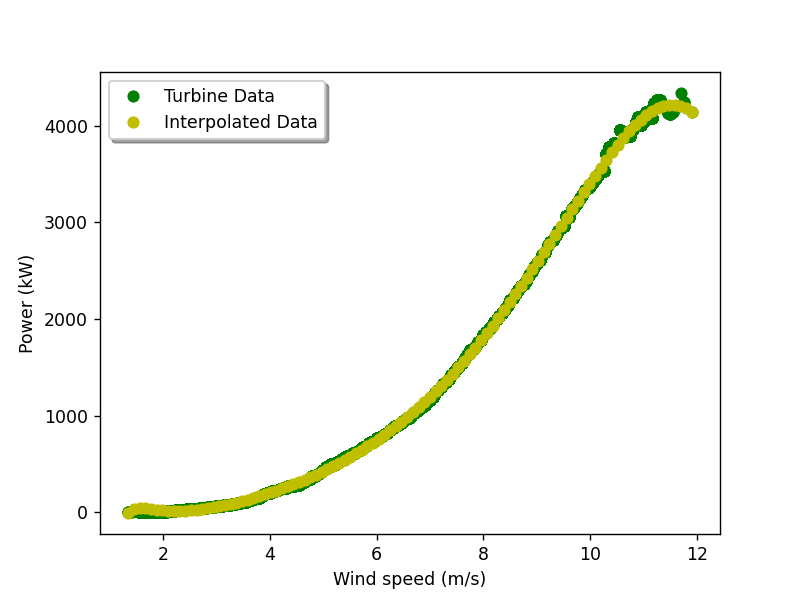

In [13]:
#plot results
fig, ax = plt.subplots()
ax.plot(x, y, 'go', label='Turbine Data')
ax.plot(xP, yP, 'yo', label='Interpolated Data')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
plt.ion()
plt.show()

## Apply interpolation for MetEirean Data

In [14]:
# import me data
%store -r me

In [15]:
min(di['Windspeed'])

2.095959666666667

In [16]:
me['windspeed'] = np.sqrt(me['u100wind'].pow(2) + me['v100wind'].pow(2))
#values greater than 1 for windspeed
me=me[(me.windspeed > 2.1) & (me.windspeed <11)]
me=me.sort_values(by=['windspeed'])
me.head(5)

,period,u100wind,v100wind,windspeed
32238,2021-04-12 07:00:00,1.923,-0.846,2.100868
38502,2021-04-12 07:00:00,1.923,-0.846,2.100868
28350,2021-04-12 07:00:00,1.923,-0.846,2.100868
28134,2021-04-12 07:00:00,1.923,-0.846,2.100868
32619,2021-04-14 04:00:00,-2.026,-0.558,2.101438


In [17]:
w, p = di['Windspeed'].values, di['Power'].values

# Interpolate (w,p)
f = si.interp1d(w, p, kind='linear')

# Apply interpolation curve to windspeed values in forecast to get power.
me['power'] = me['windspeed'].apply(f).round(3)

#round to 1 decimal to make a join later, with df1
me["windspeed"] = me["windspeed"].round(1)
me

,period,u100wind,v100wind,windspeed,power
32238,2021-04-12 07:00:00,1.923,-0.846,2.1,16.517
38502,2021-04-12 07:00:00,1.923,-0.846,2.1,16.517
28350,2021-04-12 07:00:00,1.923,-0.846,2.1,16.517
28134,2021-04-12 07:00:00,1.923,-0.846,2.1,16.517
32619,2021-04-14 04:00:00,-2.026,-0.558,2.1,16.507
...,...,...,...,...,...
58430,2021-05-21 09:00:00,3.165,-10.533,11.0,4090.598
58862,2021-05-21 09:00:00,3.165,-10.533,11.0,4090.598
57998,2021-05-21 09:00:00,3.165,-10.533,11.0,4090.598
14295,2021-03-12 04:00:00,7.582,7.968,11.0,4090.897


### Compare ME interpolated values with Turbine data

Dataframes: <br>
me = data from MetEirean  <br>
df1 = data from Turbine/Plant No1  <br>
df2 = data from Turbine/Plant No2   <br>

In [ ]:
#Full df with MetEirean Interpolated values and turbine values
data_check = pd.merge(me[["windspeed","power"]], dfcalc[["Loc/Wec/CalcP","Loc/Wec/CalcVwind","Median_power"]], left_on="windspeed",right_on="Loc/Wec/CalcVwind")
#change name of columns
data_check.columns = ['WS_ME', 'Power_ME_Interpolated',"Power_turbine","Wind_turbine","Median_power_turbine"]
data_check.head(10)


In [ ]:
#calculate the difference between ME power and Median power
data_check['diff'] = data_check['Power_ME_Interpolated'] - data_check['Median_power_turbine']
data_check.head(10)

In [ ]:
#select few rows 
r1=data_check.loc[data_check["Wind_turbine"] == 2].head(1)
r2=data_check.loc[data_check["Wind_turbine"] == 4].head(1)
r3=data_check.loc[data_check["Wind_turbine"] == 6].head(1)
r4=data_check.loc[data_check["Wind_turbine"] == 8].head(1)
r5=data_check.loc[data_check["Wind_turbine"] == 10].head(1)
r6=data_check.loc[data_check["Wind_turbine"] == 12].head(1)
r7=data_check.loc[data_check["Wind_turbine"] == 14].head(1)

In [ ]:
#view results for rows selected previously
df_test = pd.DataFrame()
for i in range(14):
    r=data_check.loc[data_check["Wind_turbine"] == i].head(1)
    df_test=df_test.append(r)
#view df as a table    
display(df_test)

In [ ]:
#plot results
fig, ax = plt.subplots()
#ax.plot(data_check["Wind_turbine"], data_check["Power_turbine"], 'ro', label='Turbine Power')
ax.plot(data_check["Wind_turbine"], data_check["Median_power_turbine"], 'go', label='Median Power')
ax.plot(data_check["WS_ME"], data_check["Power_ME_Interpolated"], 'yo', label='ME_Interpolated Power')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
plt.show()

In [ ]:
data_check